<a href="https://colab.research.google.com/github/amys4932/Deep-learning/blob/main/project/DL_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# phase 0

In [1]:
import matplotlib.pyplot as plt
from google.colab import drive
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

import cv2
import numpy as np
import dlib
from PIL import Image

from google.colab import drive
drive.mount('/content/gdrive')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
%cd gdrive/MyDrive/Deep_learning/project
%ls

/content/gdrive/MyDrive/Deep_learning/project
dev/     DL_project.ipynb  MSCTD/  test.zip     train_ende.zip
dev.zip  features.npy      test/   train_ende/


In [3]:
# download the dataset to drive
!git clone https://github.com/XL2248/MSCTD

fatal: destination path 'MSCTD' already exists and is not an empty directory.


In [4]:
# add a shortcut of image data to drive then run below code.

!unzip train_ende.zip
!unzip test.zip
!unzip dev.zip

Archive:  train_ende.zip
replace train_ende/0.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
Archive:  test.zip
replace test/0.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
Archive:  dev.zip
replace dev/0.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


# MSCTDDataset

In [3]:
class MSCTDDataset(Dataset):
    def __init__(self, directory, seed=0, transform=None, data_type='train'):
        self.directory = directory
        self.seed = seed
        self.transform = transform
        self.data_type = data_type

        # load english texts
        with open(self.directory+'MSCTD/MSCTD_data/ende/english_'+self.data_type+'.txt') as file:
            self.text = [line.rstrip() for line in file]

        # load conversation data
        with open(self.directory+'MSCTD/MSCTD_data/ende/image_index_'+self.data_type+'.txt') as file:
            self.img_index = [list(map(int, line.rstrip()[1:-1].split(','))) for line in file]
            self.first_index = np.asarray([self.img_index[i][0] for i in range(self.img_index.__len__())])
            self.conversation_length = np.asarray([len(self.img_index[i]) for i in range(len(self.img_index))])

        # load sentiment of each text
        with open(self.directory+'MSCTD/MSCTD_data/ende/sentiment_'+self.data_type+'.txt') as file:
            self.sentiment = np.asarray([int(line.rstrip()) for line in file])


    def __len__(self):
        return len(self.text)

    def __getitem__(self, idx):
        print(idx)

        n_conversation = (self.first_index <= idx).sum()-1 # this idx belongs to which conversation (0,1,2,3,...)
        conversation_length = self.conversation_length[n_conversation]
        # sentiment_pattern = self.sentiment[self.first_index[n_conversation]: self.first_index[n_conversation+1]]

        if self.data_type=='train':
          image = Image.open(self.directory+'train_ende/'+str(idx)+'.jpg')
        if self.data_type=='test':
          image = Image.open(self.directory+'test/'+str(idx)+'.jpg')
        if self.data_type=='dev':
          image = Image.open(self.directory+'dev/'+str(idx)+'.jpg')

        if self.transform:
            image = self.transform(image)

        # print(self.text[idx], n_conversation, self.sentiment[idx], conversation_length)
        return self.text[idx], n_conversation, self.sentiment[idx], image, conversation_length


train_transform = transforms.Compose([
    # transforms.Resize((1000,500)),    #for detecting faces dont reshape, so batch size should be 1 for compatibility
    transforms.ToTensor()])

train_data = MSCTDDataset("", seed=0, transform=train_transform , data_type='train')
test_data = MSCTDDataset("", transform=train_transform, data_type='test')

train_dataloader = DataLoader(train_data, batch_size=1)
test_dataloader = DataLoader(test_data, batch_size=1)

# Data Analysis

In [111]:
detector = dlib.get_frontal_face_detector()

sentiment = []
length = []
n_face = []
conversation_length = []

for (t1,n_conversation,sent,img, cl) in test_dataloader:
  
  sentiment.append(sent)
  conversation_length.append(cl)  # a conversation with length k is repeated k times in this list.

  for k in range(img.shape[0]):
    length.append(t1[k].split().__len__())

    open_cv_image = np.array(transforms.ToPILImage()(img[k,:,:,:])) 
    open_cv_image = open_cv_image[:, :, ::-1].copy() 

    gray = cv2.cvtColor(open_cv_image, cv2.COLOR_BGR2GRAY)
    n_face.append(len(detector(gray)))


sentiment = torch.concat(sentiment).numpy()
conversation_length = torch.concat(conversation_length).numpy()

length = np.asarray(length)
n_face = np.asarray(n_face)


Streaming output truncated to the last 5000 lines.
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
31

In [112]:
# save extracted features
with open('features.npy', 'wb') as f:
    np.save(f, sentiment)
    np.save(f, length)
    np.save(f, n_face)
    np.save(f, conversation_length)

In [6]:
# load the features
with open('features.npy', 'rb') as f:
    sentiment = np.load(f)
    length = np.load(f)
    n_face = np.load(f)
    conversation_length = np.load(f)

print(sentiment, length, n_face, conversation_length)

[1 1 1 ... 0 0 0] [3 7 9 ... 5 8 6] [1 1 1 ... 0 3 1] [6 6 6 ... 9 9 9]


# results

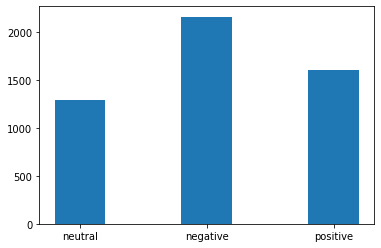

In [7]:
# sentiment priory distribution
hist = np.histogram(sentiment, 3)
plt.bar(['neutral','negative','positive'], hist[0], width = 0.4)
plt.show()

# the classes are imbalanced and we should consider this fact in our model design.

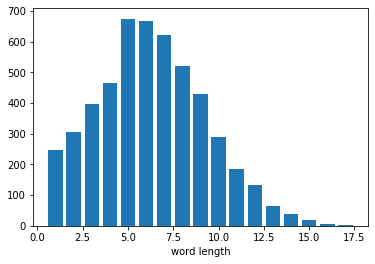

length mean: 6.303927373199132
length std.: 2.9820842533427196


In [114]:
# sentence length distribution
unique, counts = np.unique(length, return_counts=True)
plt.bar(unique, counts)
plt.xlabel('word length')
plt.show()

# plt.hist(length, bins=length.max())
# plt.xlabel('word length')
# plt.show()

print(f"length mean: {length.mean()}")
print(f"length std.: {length.std()}")

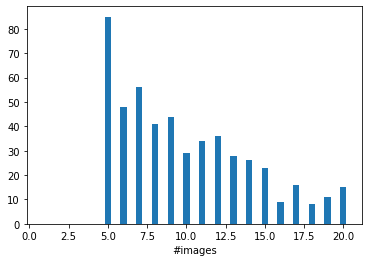

conversation length mean: 9.954813359528487
conversation length std.: 4.213357164986483


In [8]:
# conversation length (number of images) distribution
hist = np.histogram(conversation_length, np.arange(1, conversation_length.max()+2))   # a conversation with length k is repeated k times in this list.
rng = np.arange(1, conversation_length.max()+1)
temp = hist[0]/rng

plt.bar(rng, temp, width = 0.4)
plt.xlabel('#images')
plt.show()

mean = (temp*rng).sum()/temp.sum()
std = np.sqrt((temp*rng**2).sum()/temp.sum() - mean**2)
print(f"conversation length mean: {mean}")
print(f"conversation length std.: {std}")

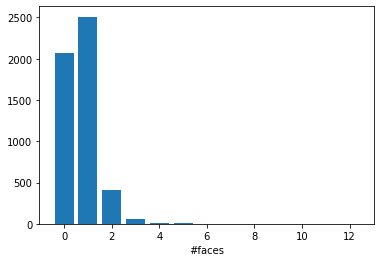

#face mean: 0.7146240378922439
#face std.: 0.7400876257989344


In [116]:
# face number distribution
unique, counts = np.unique(n_face, return_counts=True)
plt.bar(unique, counts)
plt.xlabel('#faces')
plt.show()

# plt.hist(n_face, bins=n_face.max())
# plt.xlabel('#faces')
# plt.show()

print(f"#face mean: {n_face.mean()}")
print(f"#face std.: {n_face.std()}")

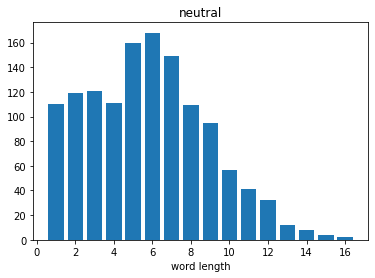

length mean: 5.776579352850539
length std.: 3.0952033087656337



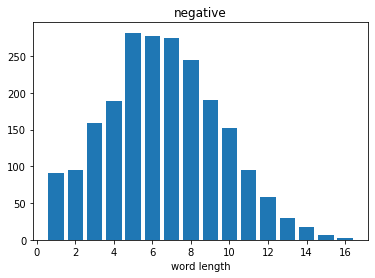

length mean: 6.561257512713824
length std.: 2.9392550485124502



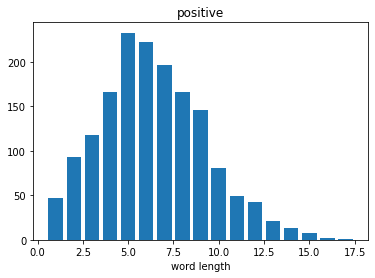

length mean: 6.383561643835616
length std.: 2.8911043651923327



In [10]:
# sentiment correlation with conversation length
S = {0:'neutral',1:'negative',2:'positive'}
for i in S.keys():
  temp = length[sentiment==i]

  unique, counts = np.unique(temp, return_counts=True)
  plt.bar(unique, counts)
  plt.title(S[i])
  plt.xlabel('word length')
  plt.show()

  print(f"length mean: {temp.mean()}")
  print(f"length std.: {temp.std()}\n")

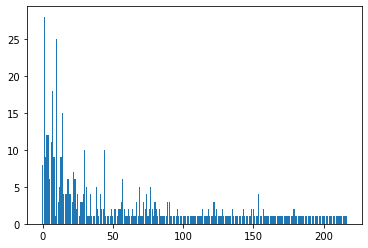

#conversations: 509 
#unique sentiment patterns: 217 
theoritical number of patterns for a conversation with length 6: 96


In [11]:
# sentiment temporal pattern

pattern = []
for n_conversation in range(len(test_data.img_index)):
    sentiment_pattern = test_data.sentiment[test_data.img_index[n_conversation]]
    temp = np.diff(np.concatenate([[-1], np.array(sentiment_pattern)]))
    temp = sentiment_pattern[temp!=0]
    pattern.append(np.array([temp[i]*3**i for i in range(len(temp))]).sum()) # we can imagine a string of 0,1,2 numbers (sentiment_pattern) as a base 3 number and convert it to a decimal for easier representation

unique, counts = np.unique(pattern, return_counts=True)
plt.bar(np.arange(len(counts)), counts)
plt.show()

print('#conversations:', len(pattern), '\n#unique sentiment patterns:', len(set(pattern)), '\ntheoritical number of patterns for a conversation with length 6:', 3*2**5)